In [1]:
import __casac__ as cc
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.io import fits as pf
from dsacalib.utils import *
from dsacalib.calib import * 
from dsacalib.plotting import *
%matplotlib inline

/home/simard/anaconda3/envs/casa/lib/python3.6/site-packages/matplotlib/__init__.py:576: UserWarning: matplotlibrc text.usetex can not be used with *Agg backend unless dvipng-1.6 or later is installed on your system
  'your system' % dvipng_req)


In [2]:
# Define the file, source and pointing parameters
datadir= '/home/simard/dsa_calib/data'
fl     = '{0}/J1459+7140/flagged.fits'.format(datadir) 
cal    = src('J1459+7140',7.47,'14h59m07.63s','+71d40m19.9s')
sr0    = src('J1520+7225',1.5491,'15h20m47.46s','+72d25m04.80s')
antenna_order = [8,5,7,4,3,0,9,1,6,2]

## Find calibration solutions using calibrator

In [3]:
fobs, blen, bname, tstart, tstop, vis, mjd, transit_idx = \
    read_psrfits_file(fl,cal,antpos='{0}/antpos_ITRF.txt'
                      .format(datadir))

File covers 1.01 h hours from MJD 58753.9250881348 to 58753.967096419525


In [4]:
vis = vis/visibility_model(blen,[cal],mjd,fobs)

#### Write 10-s fringe-stopped visibilities to ms

In [5]:
convert_to_ms(cal,vis,tstart,'{0}.ms'.format(cal.name),bname,
             antpos='{0}/antpos_ITRF.txt'.format(datadir))

#### Delay calibration

In [6]:
delay_calibration('{0}'.format(cal.name),prefix=cal.name)

#### Use deviations from average delay calibration to flag bad times

In [7]:
bad_times,times = get_bad_times(cal)
flag_badtimes('{0}'.format(cal.name),times,bad_times)

/home/simard/anaconda3/envs/casa/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['lmodern'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


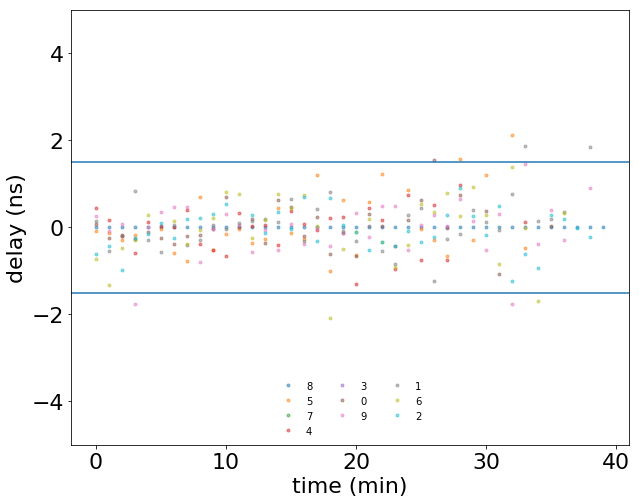

In [8]:
times, antenna_delays, kcorr = plot_antenna_delays(cal,antenna_order)

#### Flag antennas that we know are bad and short baselines with crosstalk

In [9]:
flag_antenna('{0}'.format(cal.name),4)
flag_antenna('{0}'.format(cal.name),2)
flag_antenna('{0}'.format(cal.name),"3,5,7,9&")

#### Gain calibration

In [10]:
gain_calibration(cal)

#### Look at solutions

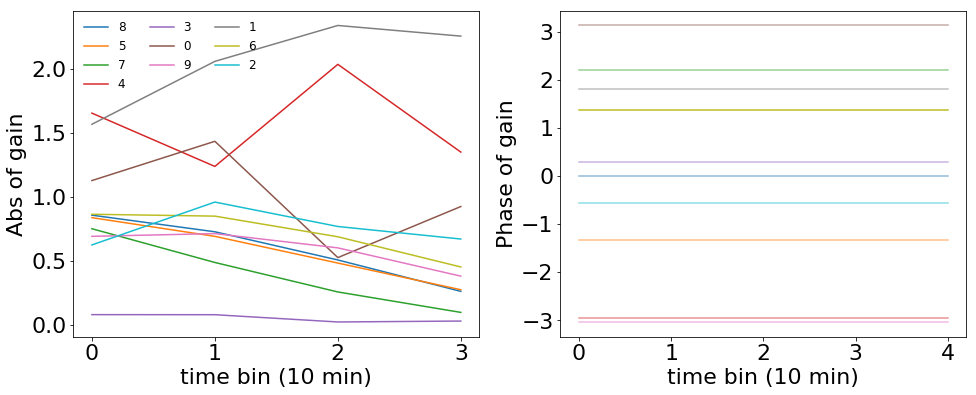

In [11]:
plot_gain_calibration(cal,antenna_order)

Image shape: [256 256   1   1]
Peak SNR at pix (147,0) = 5.997040241295448
Value at peak: 1.4895861148834229
Value at origin: 1.112013816833496
1 errors occured during imaging


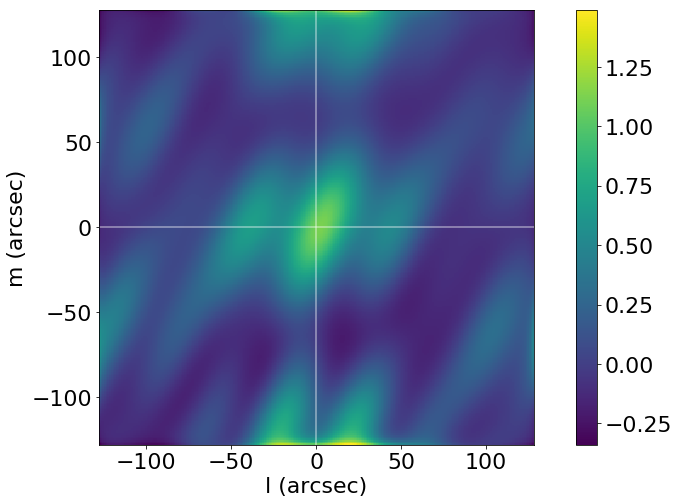

In [12]:
plot_image('{0}'.format(cal.name),'corrected',cal,verbose=True)

## Apply solution to target source

In [13]:
fobs, blen, bname, tstart, tstop, vis, mjd, transit_idx = \
    read_psrfits_file(fl,sr0,antpos='{0}/antpos_ITRF.txt'
                      .format(datadir))

File covers 1.01 h hours from MJD 58753.9250881348 to 58753.967096419525


In [14]:
vis = vis/visibility_model(blen,[sr0],mjd,fobs,phase_only=True)

In [15]:
convert_to_ms(sr0,vis,mjd[0],'{0}.ms'.format(sr0.name),bname,
             antpos='{0}/antpos_ITRF.txt'.format(datadir))

#### Flag bad antennas and short baselines

In [16]:
flag_antenna('{0}'.format(sr0.name),4)
flag_antenna('{0}'.format(sr0.name),2)
flag_antenna('{0}'.format(sr0.name),"3,5,7,9&")

#### Calibrate

In [17]:
apply_calibration(sr0,cal)

#### Look at calibrated data

In [18]:
ms = cc.ms.ms()
ms.open('{0}.ms'.format(sr0.name))
data = ms.getdata(['corrected_data'])
vis_cal = data['corrected_data'][0,...].reshape(625,-1,45).T
ms.close()
mjd = np.mean(mjd[:25])+np.arange(vis_cal.shape[1])*np.median(np.diff(mjd))*25

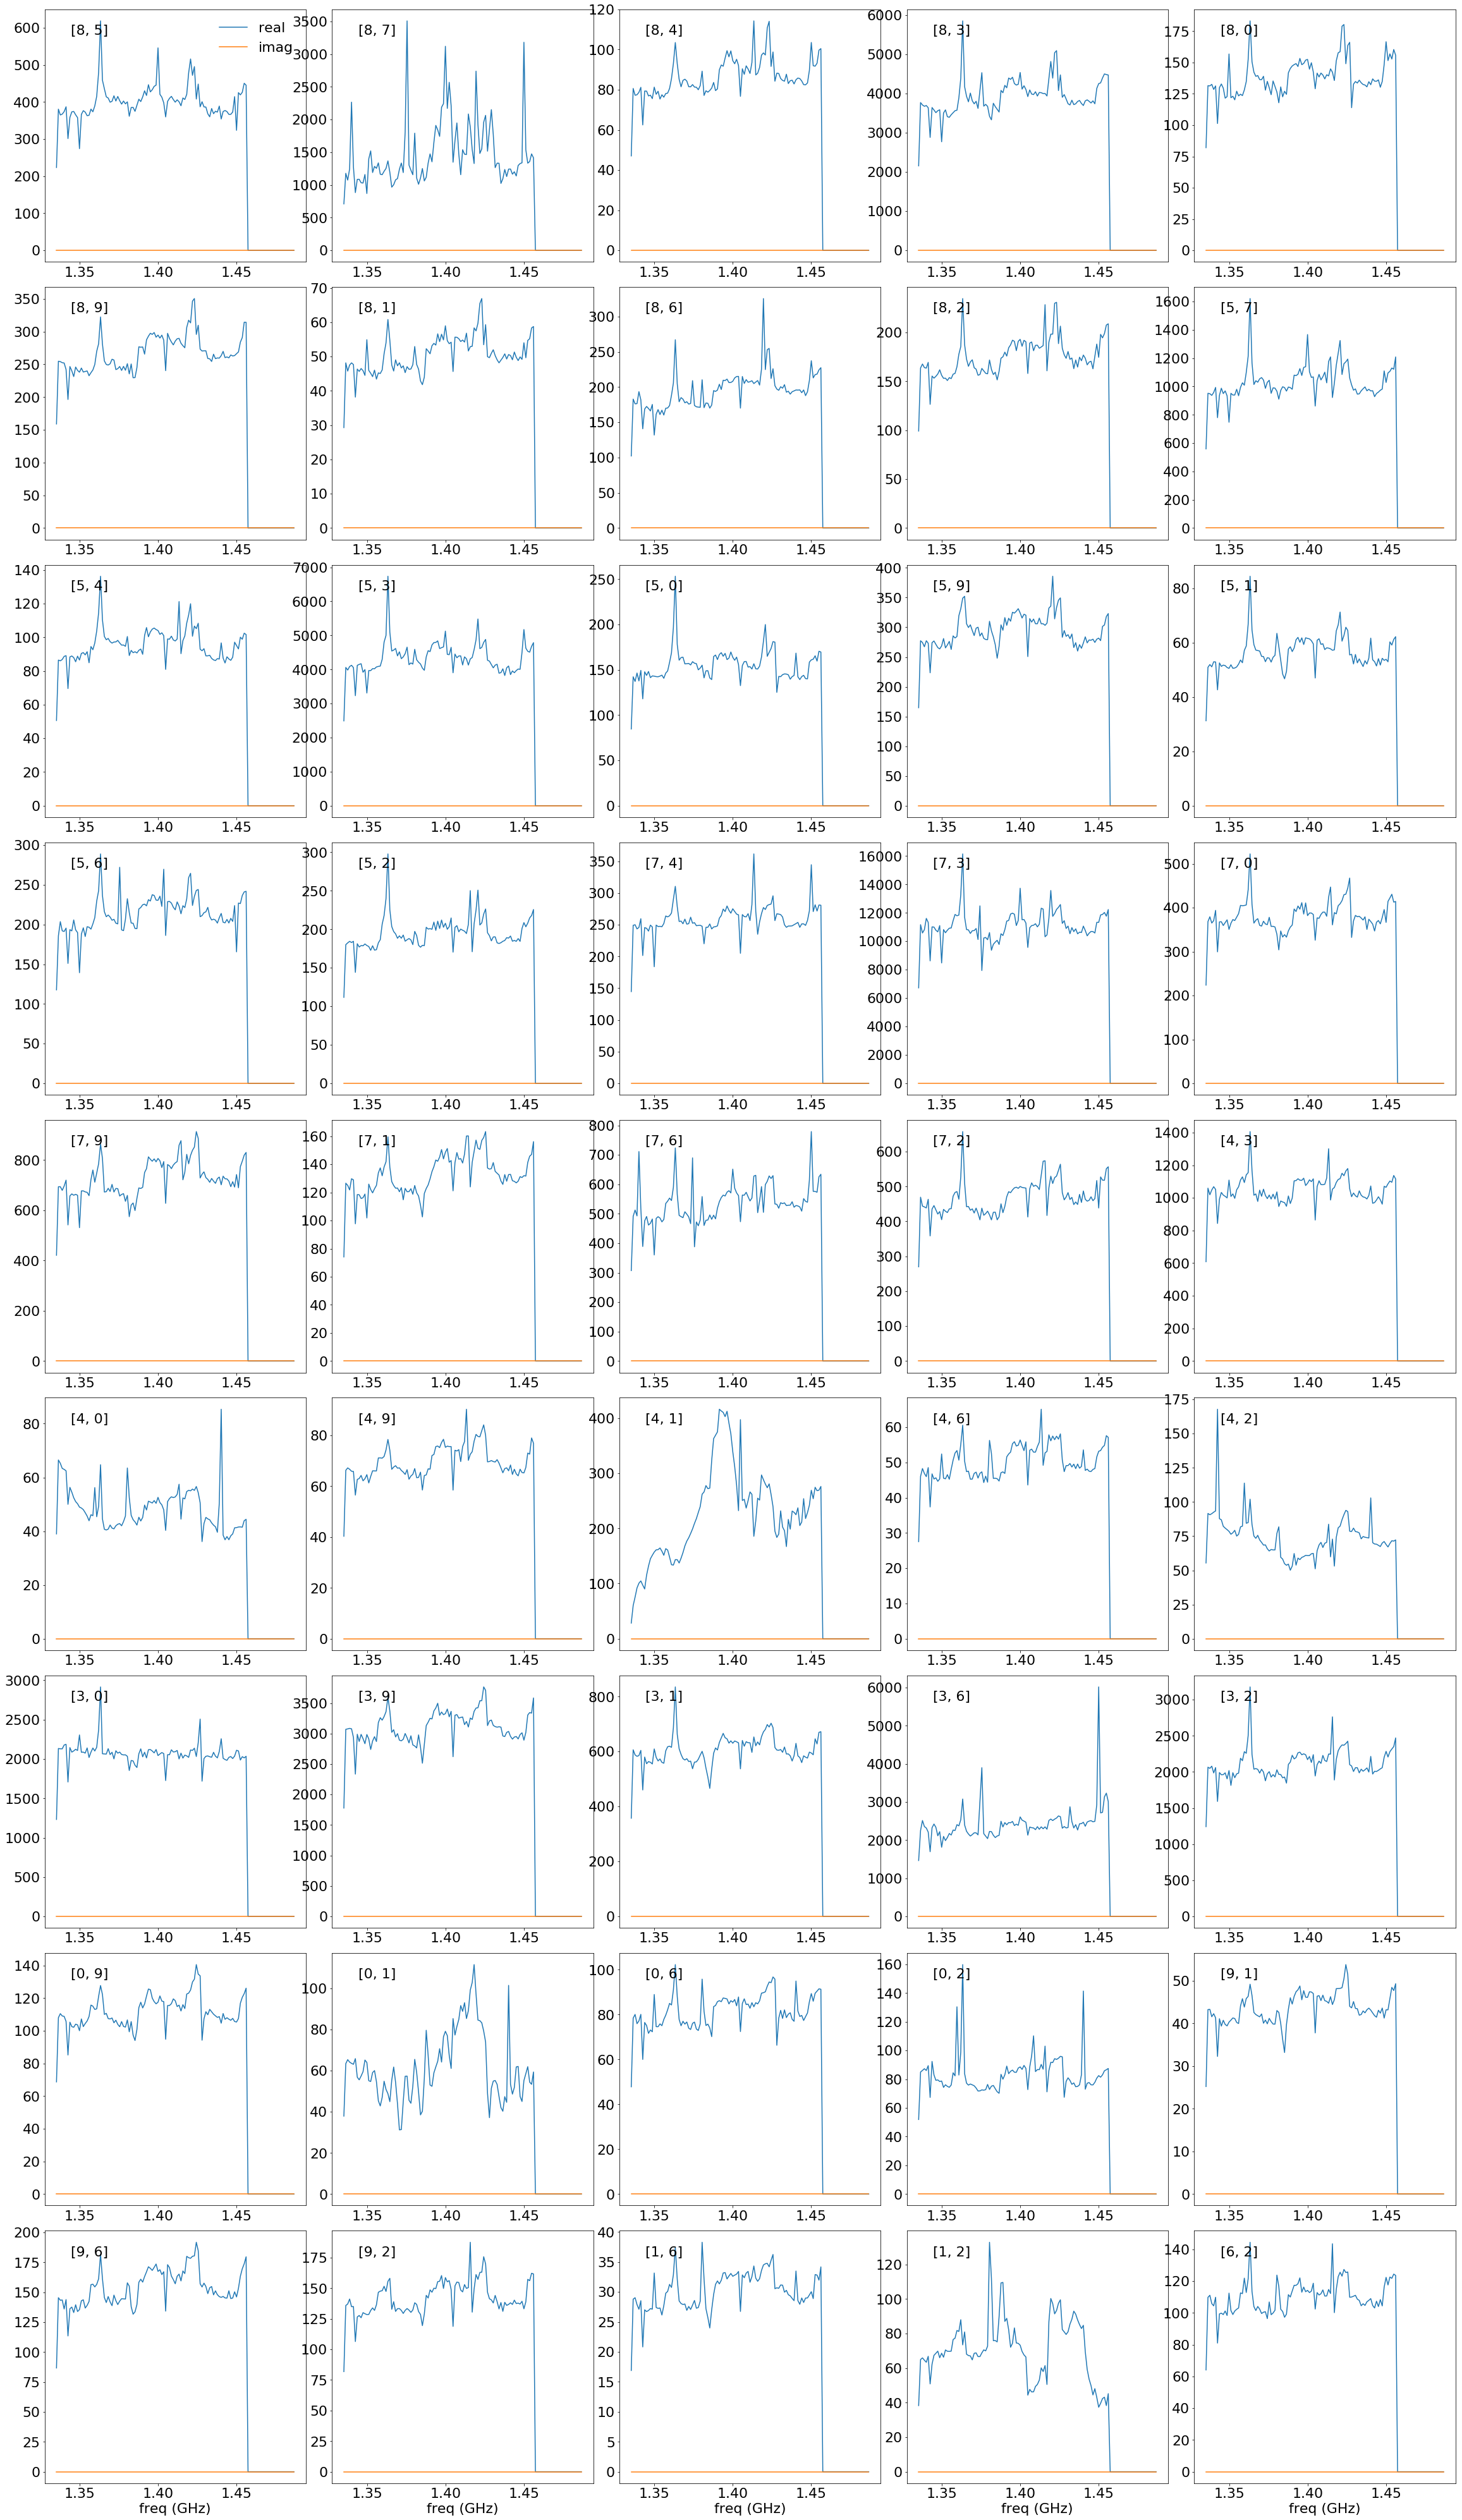

In [19]:
plot_vis_freq(np.abs(vis_cal),fobs,bname)

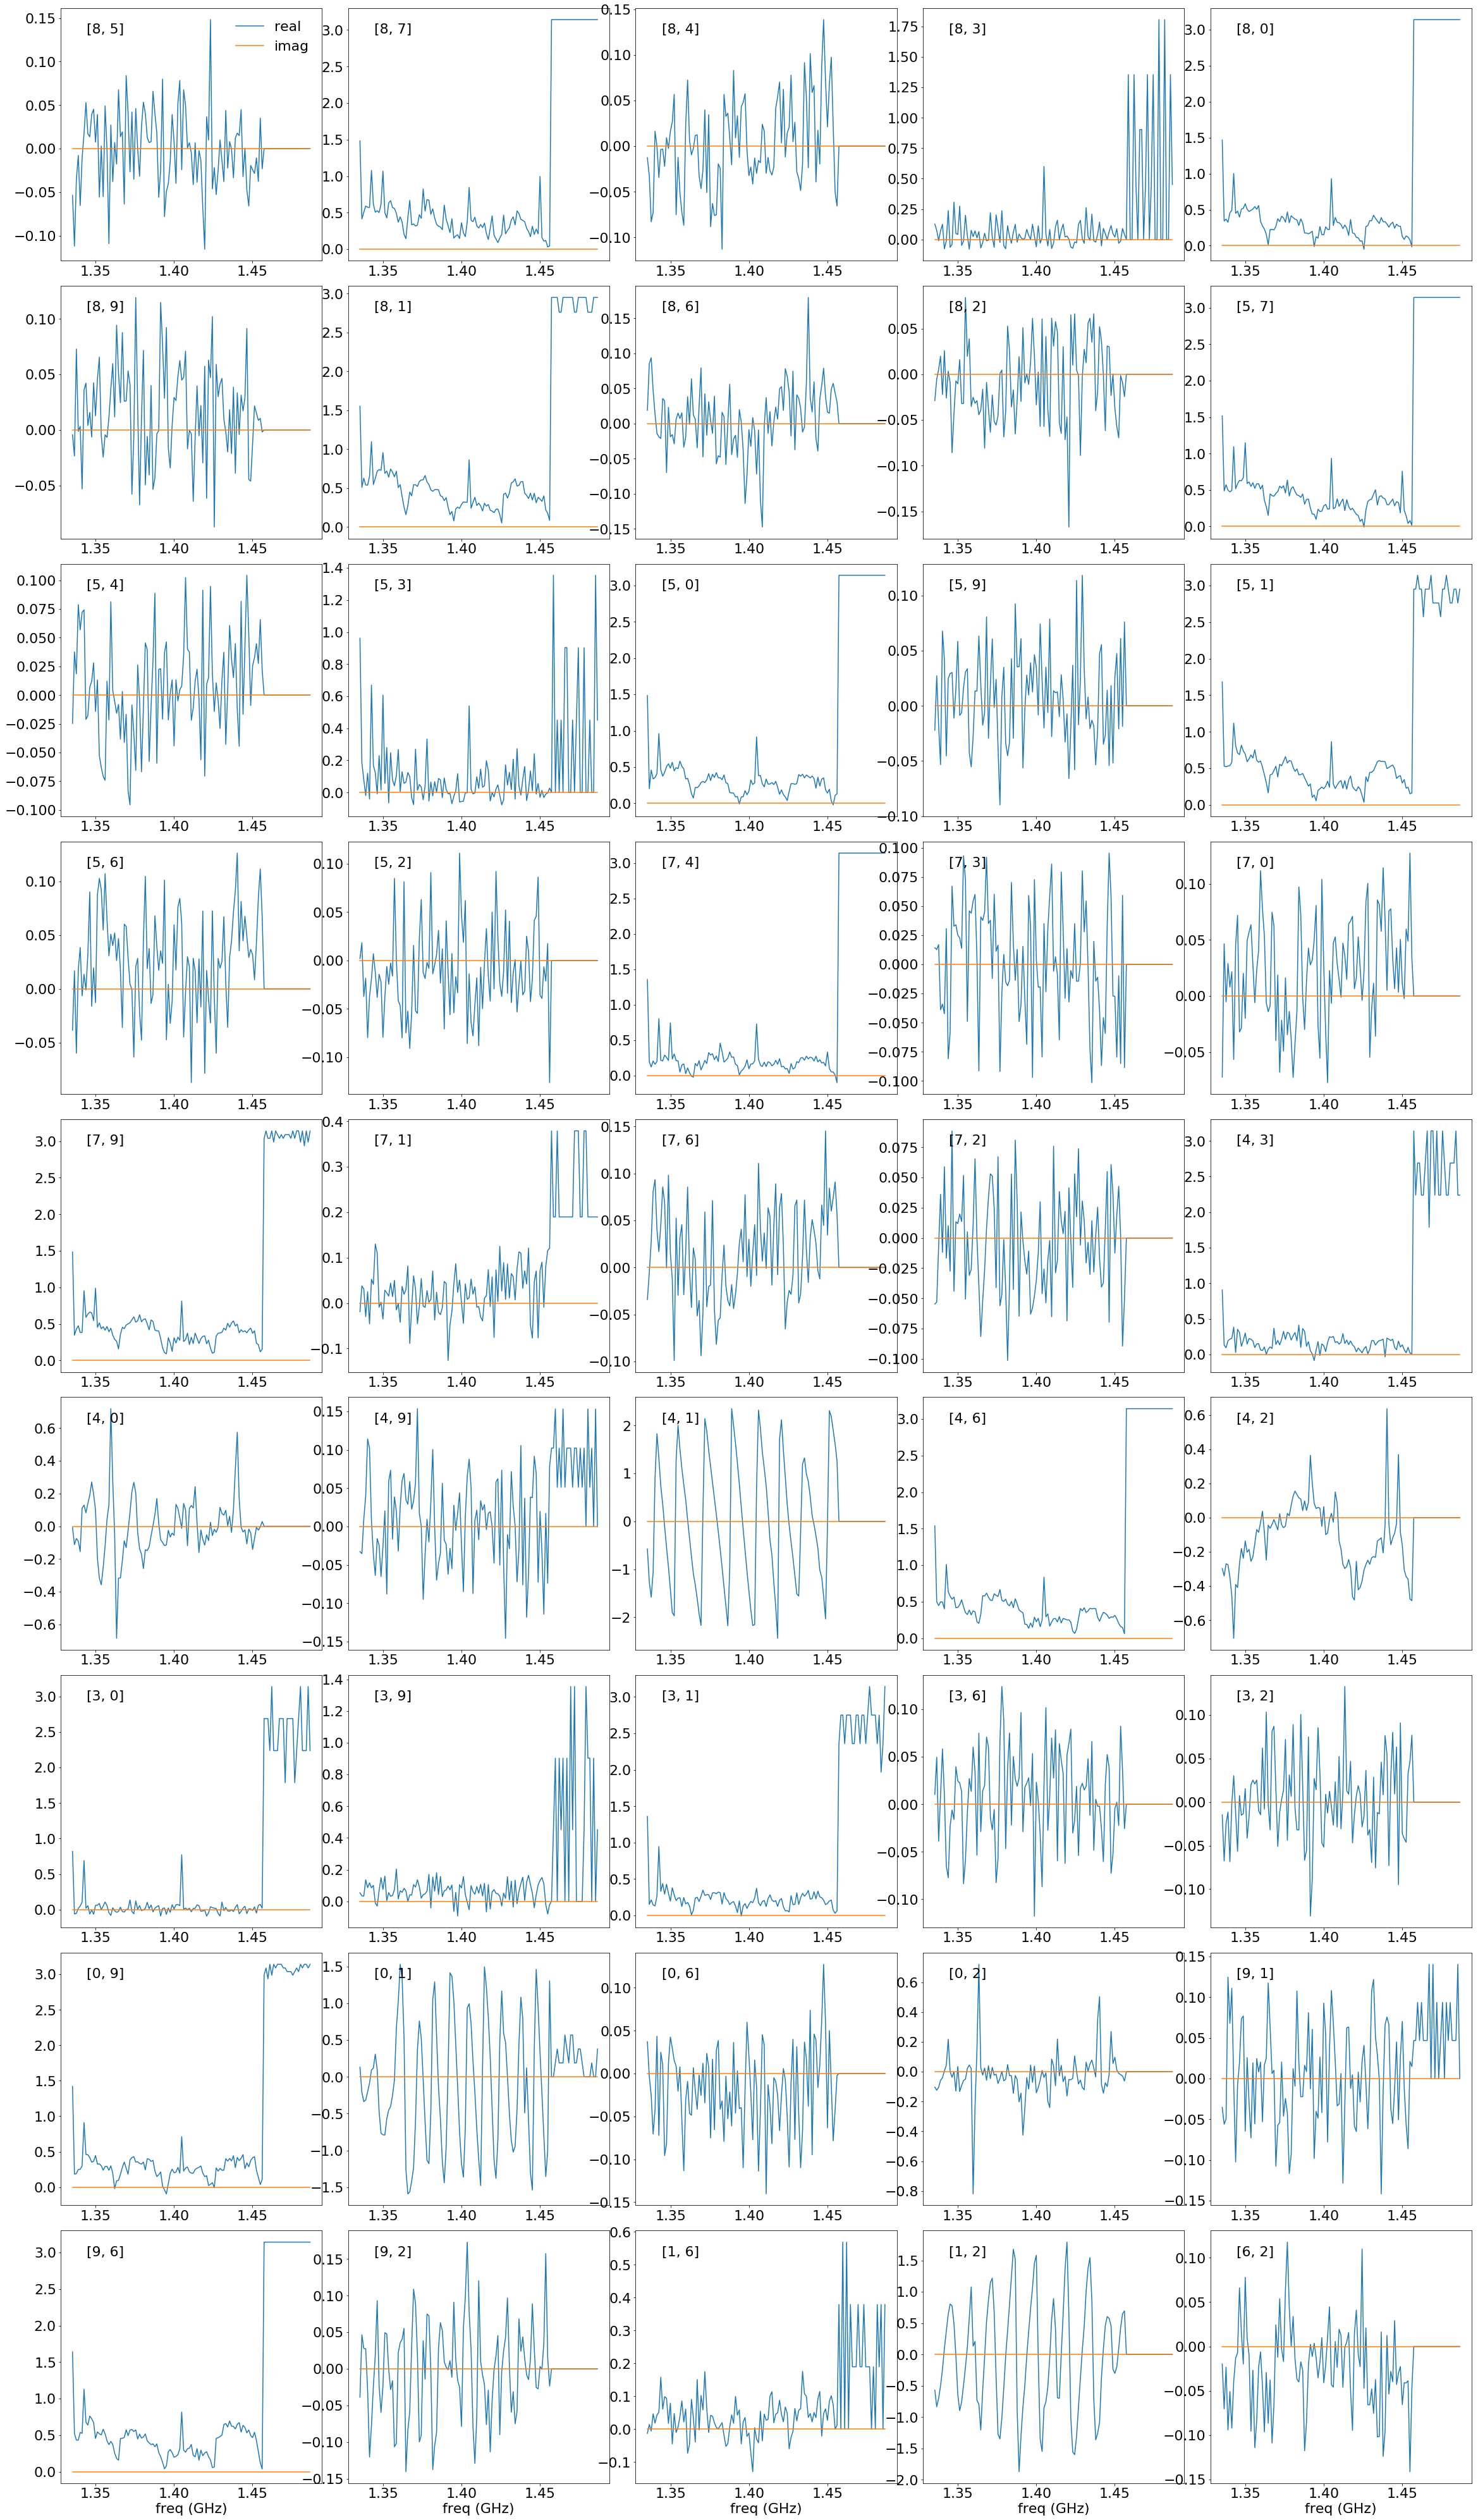

In [20]:
plot_vis_freq(np.angle(vis_cal),fobs,bname)

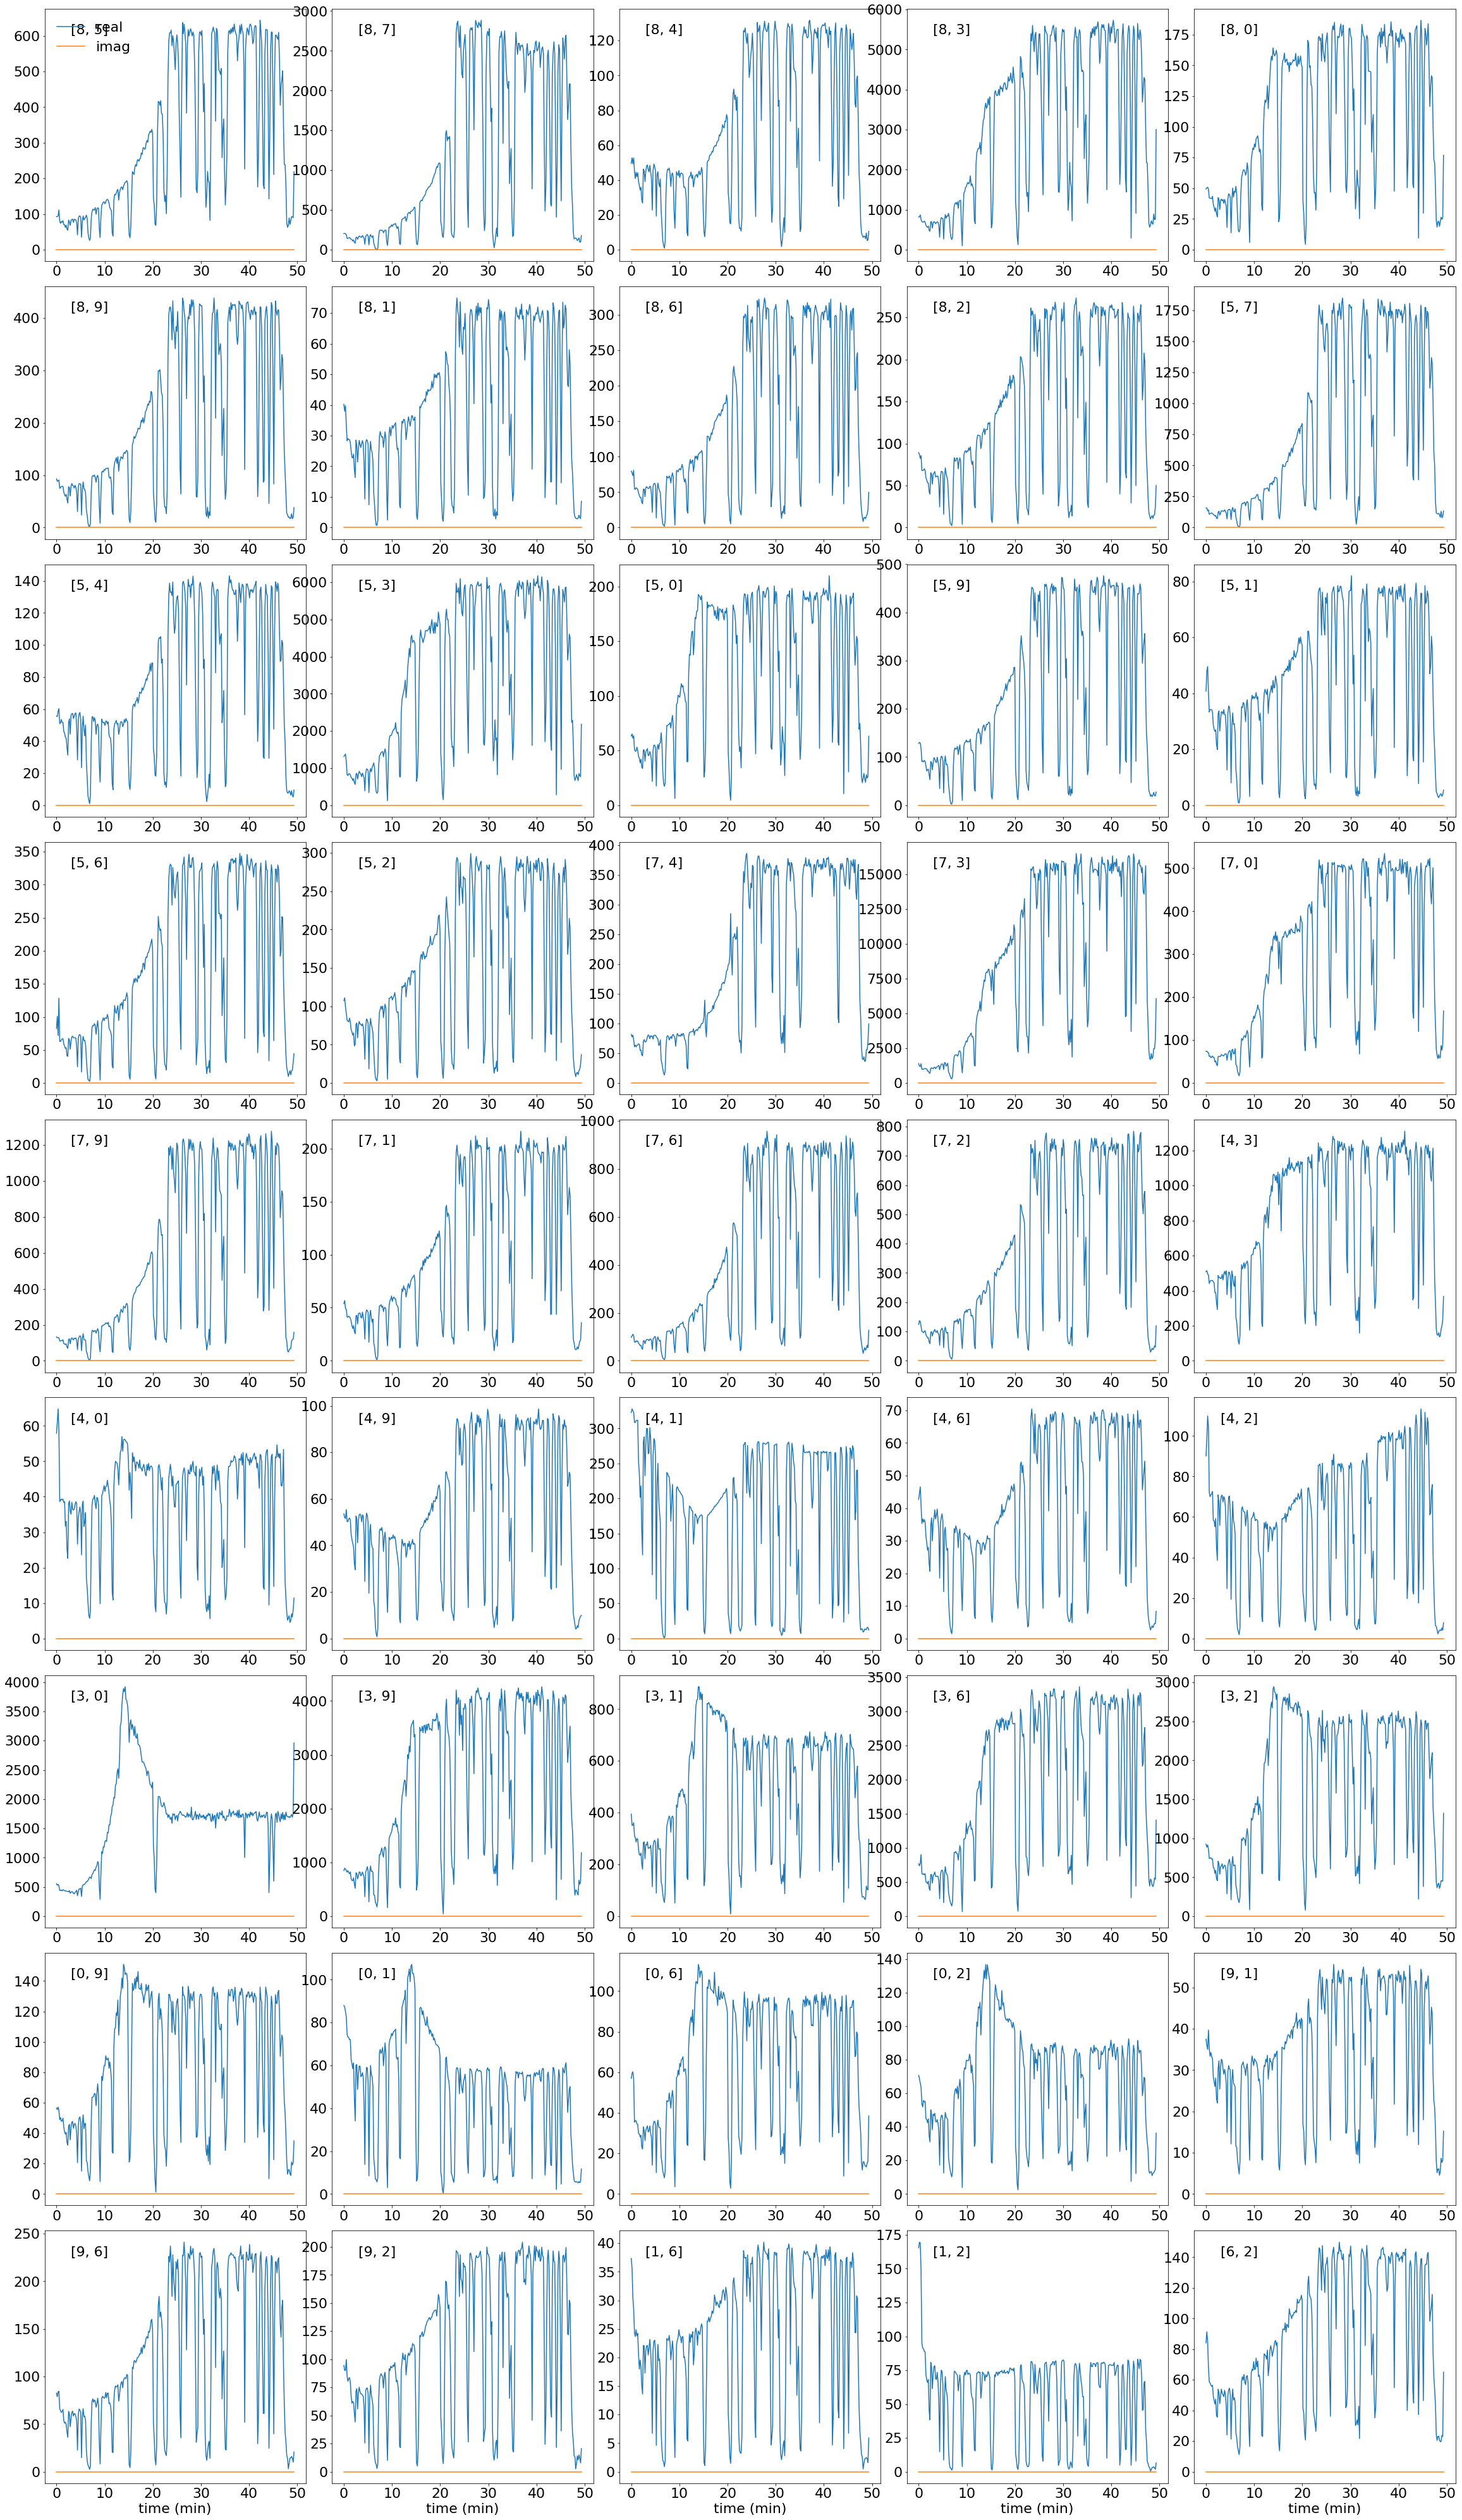

In [21]:
plot_vis_time(np.abs(vis_cal),mjd,bname)

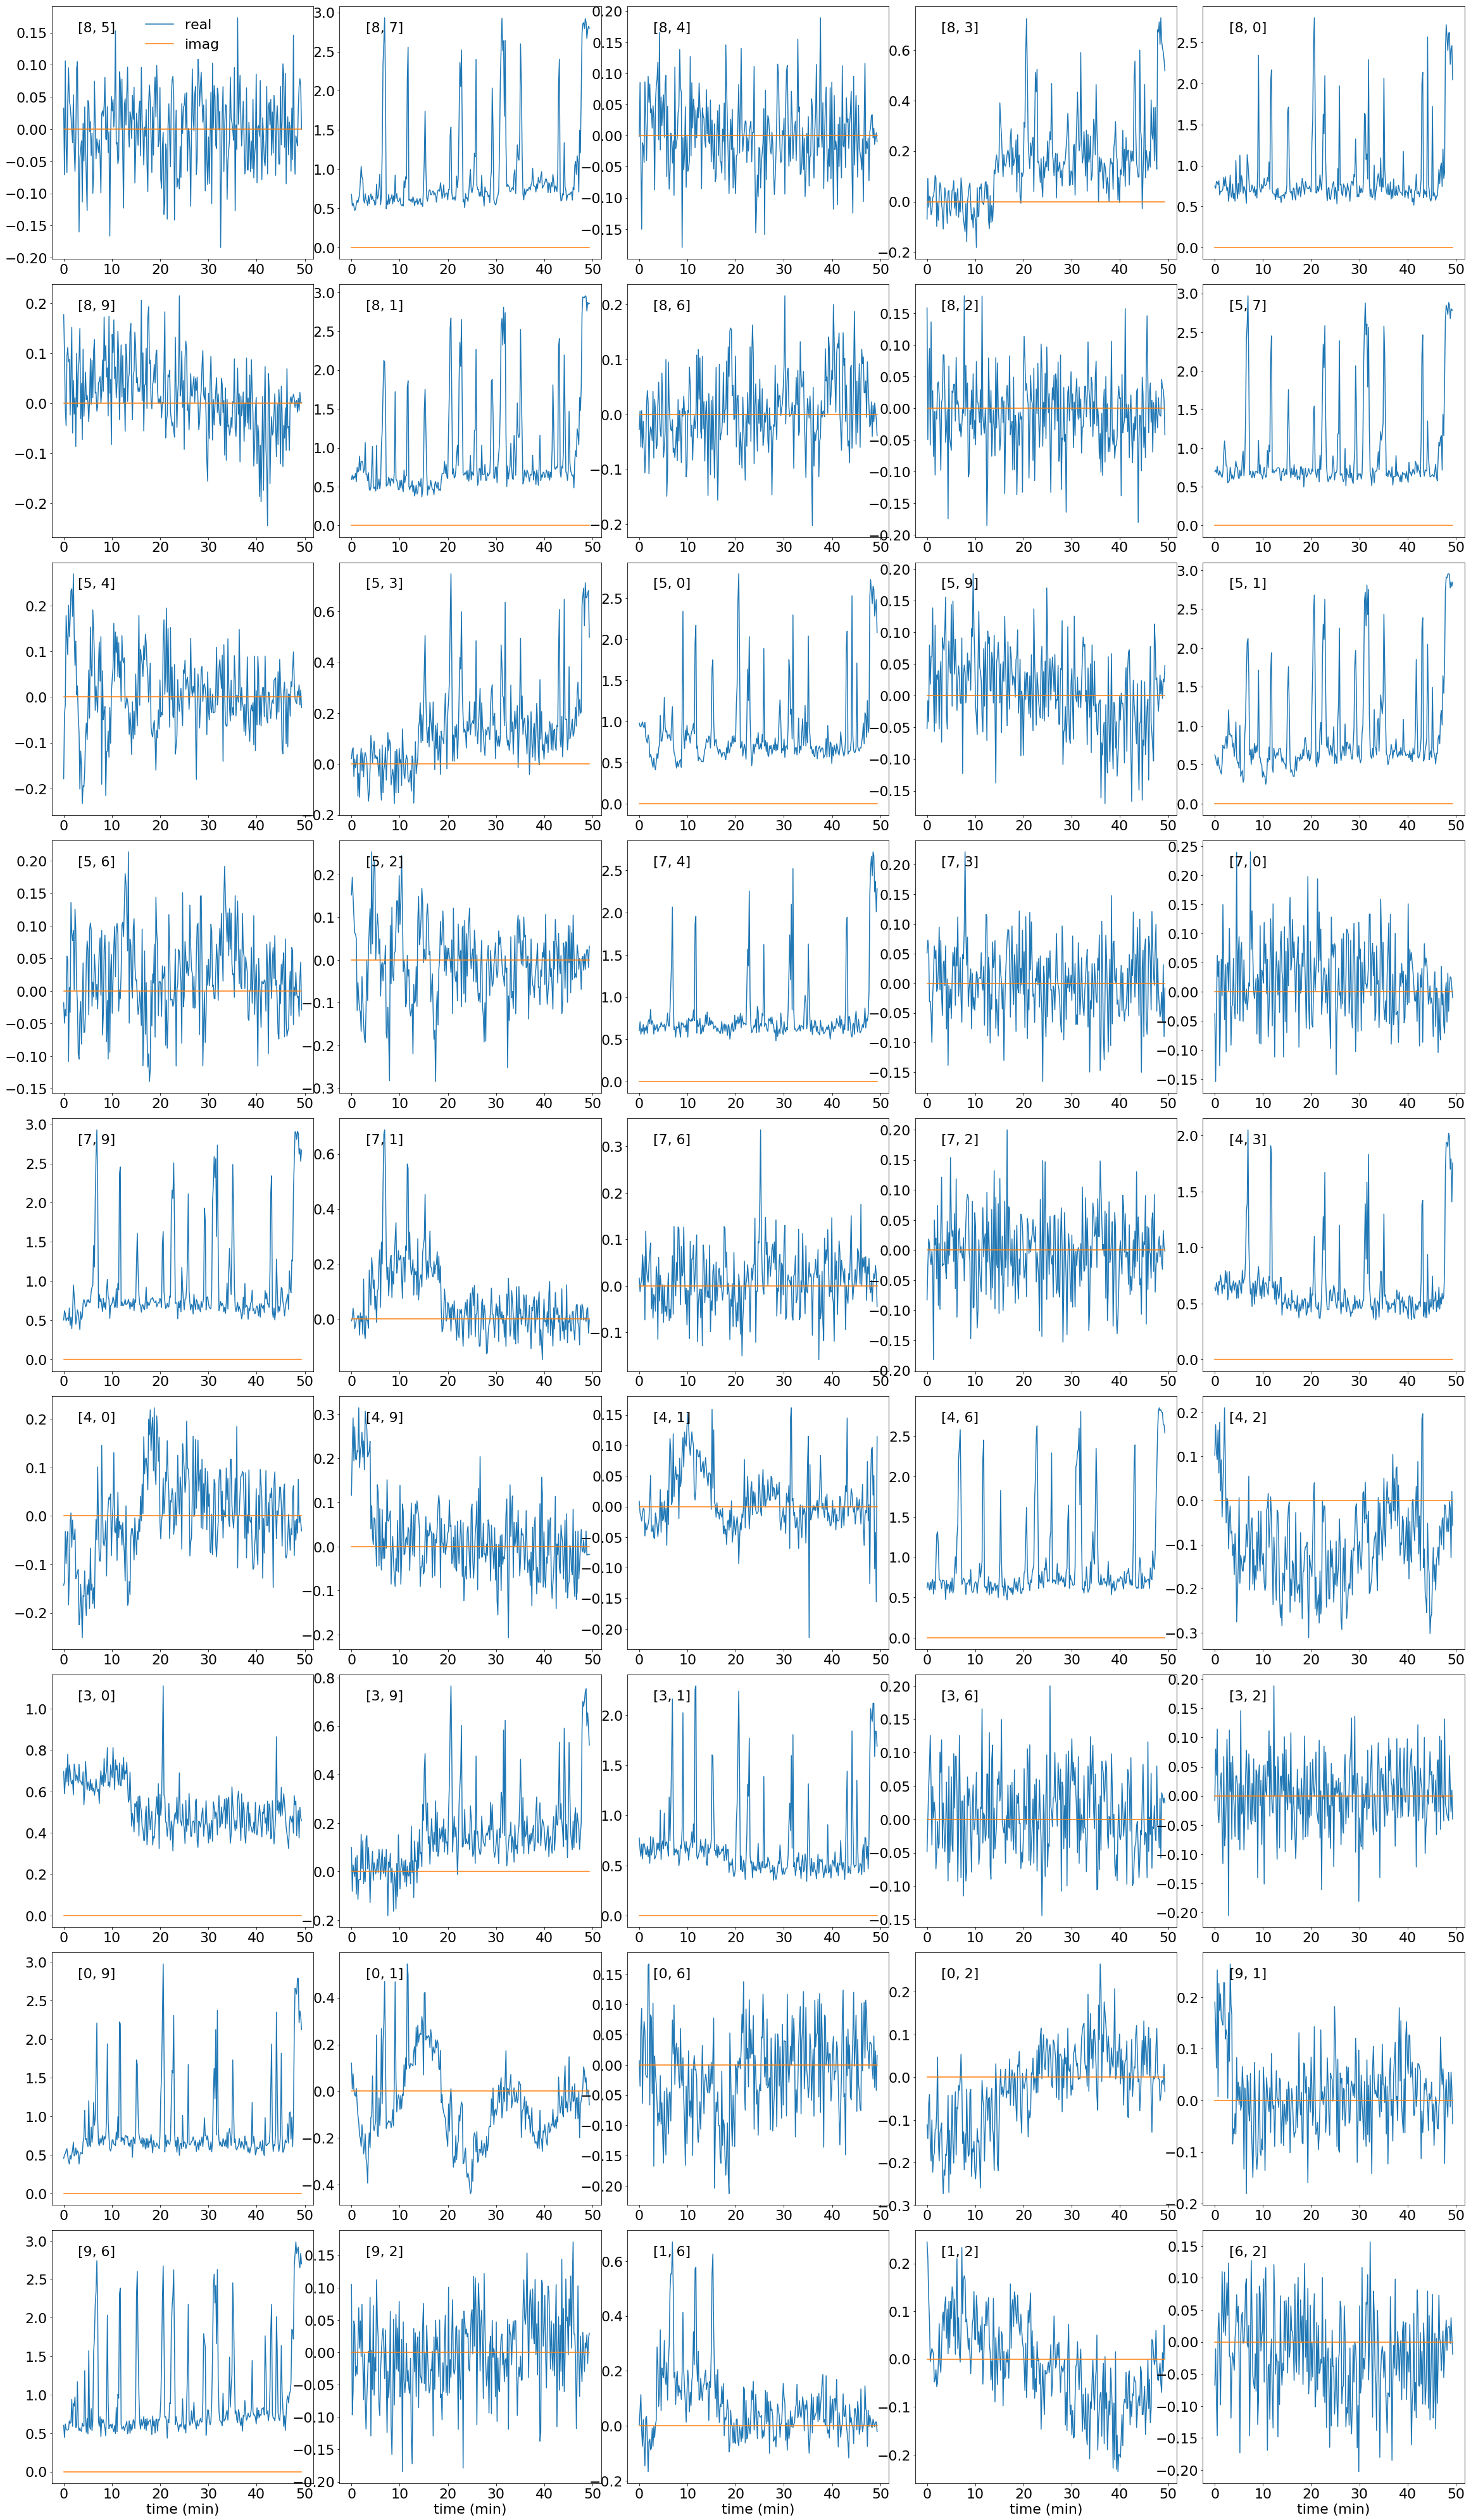

In [22]:
plot_vis_time(np.angle(vis_cal),mjd,bname)

Image shape: [128 128   1   1]
Peak SNR at pix (64,68) = 2.983440073969249
Value at peak: 6.581690788269043
Value at origin: 6.5371904373168945
1 errors occured during imaging


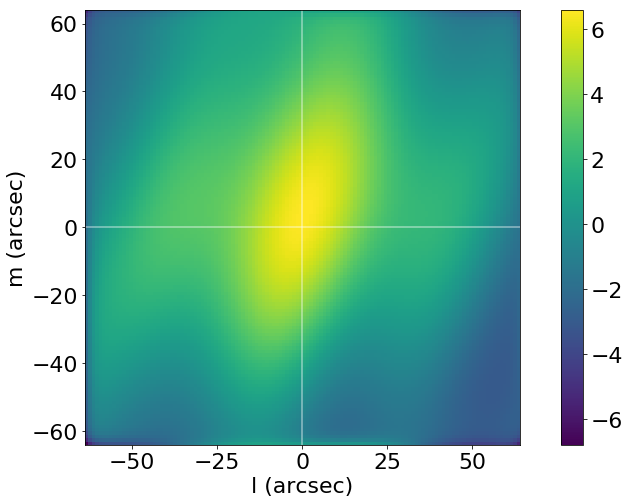

In [23]:
plot_image('{0}'.format(sr0.name),'corrected',sr0,verbose=True,
          npix=128)

Image shape: [256 256   1   1]
Peak SNR at pix (128,132) = 3.266895309934841
Value at peak: 6.582708358764648
Value at origin: 6.537397384643555
1 errors occured during imaging


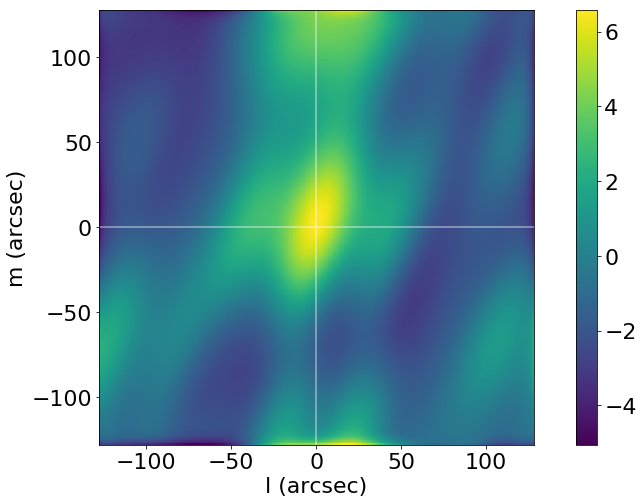

In [24]:
plot_image('{0}'.format(sr0.name),'corrected',sr0,verbose=True)